# Experiment  0: ToM Overall Model Performance


In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import pymc
import networkx as nx
import matplotlib.pyplot as plt
import random
import torch

In [3]:
import sys
import os
import osmnx as ox

# Adjust this path as needed to point to your project root
sys.path.append(os.path.abspath(".."))

In [4]:
def plot_goal_distribution(goal_distribution):
    """
    Plot the goal distribution as a bar plot.

    Parameters
    ----------
    goal_distribution : dict
        Dictionary mapping candidate goal IDs to probability values.
    """
    # Extract goal IDs and probabilities, converting to floats if needed.
    goals = list(goal_distribution.keys())
    probs = [float(goal_distribution[g]) for g in goals]
    
    # Create the bar plot.
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(goals)), probs, tick_label=[str(g) for g in goals])
    plt.xlabel("Candidate Goal IDs")
    plt.ylabel("Probability")
    plt.title("Posterior Distribution over Candidate Goals")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [5]:
def visualize_map(campus,
                  path=None,
                  goal_nodes=None,
                  ax=None):
    """
    Visualize the campus map, plus optional trajectory, start, waypoint, and goal nodes.
    
    Arguments:
      campus         an object with:
                        - campus.G           : a networkx graph
                        - campus.node_coords : dict[node] -> (x, y) coordinates
                        - campus.buildings   : a GeoDataFrame of building footprints (or None)
      path           list of node‐IDs, the agent’s trajectory to draw (in order)
      start_nodes    list of node‐IDs to mark as start(s)
      waypoint       single node‐ID to mark as an intermediate waypoint
      goal_nodes     list of node‐IDs to mark as goal(s)
      ax             optional matplotlib Axes onto which to draw
      
    Returns:
      fig, ax        the figure & axis
    """
    # 1) draw the base map
    if ax is None:
        fig, ax = ox.plot_graph(campus.G,
                                figsize=(15,15),
                                node_size=5,
                                edge_color="#999999",
                                show=False,
                                close=False)
    else:
        fig = ax.figure
        ox.plot_graph(campus.G,
                      ax=ax,
                      node_size=5,
                      edge_color="#999999",
                      show=False)
    
    # 2) overlay buildings if you have them
    if getattr(campus, "buildings", None) is not None:
        campus.buildings.plot(ax=ax,
                              color="#bbbbbb",
                              alpha=0.7,
                              edgecolor="#444444")
    
    # 3) draw the agent’s path
    if path is not None and len(path) > 1:
        coords = [campus.node_coords[n] for n in path]
        xs, ys = zip(*coords)
        ax.plot(xs, ys,
                linestyle='-',
                linewidth=3.0,
                color='lightblue',
                alpha=0.8,
                zorder=3,
                label="Trajectory")
        # and mark the actual visited nodes
        ax.scatter(xs, ys,
                   c='C0',
                   s=30,
                   zorder=4)
    
    # 6) mark goal nodes
    if goal_nodes:
        goal_coords = [campus.node_coords[n] for n in goal_nodes]
        xs, ys = zip(*goal_coords)
        ax.scatter(xs, ys,
                   c="yellow",
                   s=160,
                   marker="*",
                   zorder=5,
                   label="Goal")
    
    # 7) finalize
    ax.legend(loc="upper right")
    ax.set_title("UCSD Campus Environment")
    ax.set_axis_off()
    fig.tight_layout()
    return fig, ax

In [6]:
from real_world_src.environment.campus_env import CampusEnvironment
from real_world_src.agents.agent_factory import AgentFactory
from real_world_src.simulation.simulator import Simulator
#from real_world_src.simulation.experiment_1 import Simulator

from real_world_src.utils.run_manager import RunManager
from real_world_src.utils.config import VISUAL_CONFIG
from real_world_src.utils.config import get_agent_color


## Steps  
1. Create the UCSD campus world
2. Create n agents each with a specific distribution over the goals
3. Run m epsiodes where each agent chooses a goal and performs a single path to that goal
4. Use this data as training set

## Step 1: Create the Map

In [7]:
# Create a run manager
# run_manager = RunManager('visuals')
# run_dir = run_manager.start_new_run()

# Initialize campus environment
campus = CampusEnvironment()

Loading map data for University of California, San Diego, La Jolla, CA, USA...


Environment loaded with 3151 nodes and 8746 edges


## Step 2: Create N Agents

In [8]:
# Need to establish the set of common goals (just choose the landmark nodes)
goals = [469084068, 49150691, 768264666, 1926666015, 1926673385, 49309735,
         273627682, 445989107, 445992528, 446128310, 1772230346, 1926673336, 
         2872424923, 3139419286, 4037576308]

In [9]:
""" Already created agents and saved as pkl
# Create n agents
agents = []
n = 100
for i in range(n):
    agents.append(AgentFactory.create_agent("shortest"))
    agents[i].id = i

n_goals = len(goals)
ag_alpha = np.random.normal(1, 0.2, size=n_goals)

for agent in agents: # Set each agent's goal distribution
    agent.goal_distribution = np.random.dirichlet(alpha=np.ones(n_goals)*(ag_alpha), size=1)[0]
    agent.environment = campus

# Save the agents 
import pickle

# suppose `agents` is your list of Agent instances
with open('agents.pkl', 'wb') as f:
    pickle.dump(agents, f)

"""

' Already created agents and saved as pkl\n# Create n agents\nagents = []\nn = 100\nfor i in range(n):\n    agents.append(AgentFactory.create_agent("shortest"))\n    agents[i].id = i\n\nn_goals = len(goals)\nag_alpha = np.random.normal(1, 0.2, size=n_goals)\n\nfor agent in agents: # Set each agent\'s goal distribution\n    agent.goal_distribution = np.random.dirichlet(alpha=np.ones(n_goals)*(ag_alpha), size=1)[0]\n    agent.environment = campus\n\n# Save the agents \nimport pickle\n\n# suppose `agents` is your list of Agent instances\nwith open(\'agents.pkl\', \'wb\') as f:\n    pickle.dump(agents, f)\n\n'

In [10]:
def new_episode(agents):

    # Set the goal and start nodes
    for agent in agents:
        agent.path = [] # Clear the old path
        agent.goal_node = int(np.random.choice(goals, size=1, p=agent.goal_distribution)[0])

        while True:
            start_node = campus.get_random_node()
            try:
                path = nx.shortest_path(campus.G_undirected, 
                                       source=start_node, 
                                       target=agent.goal_node, 
                                       weight='length')
                if len(path) >15:  # Make sure path is non-trivial
                    break
            except:
                continue
        agent.start_node = start_node
        agent.current_node = start_node

    return 

## Step 3: Perform Episodes and Data Collection

In [11]:
import json

In [12]:
""" Already ran once. Data is saved in /data

path_data = {}
goal_data = {}
m = 100
for episode in range(m):
    new_episode(agents)
    episode_path_data = {}
    episode_goal_data = {}
    for agent in agents:
        agent.plan_path()
        episode_path_data[agent.id] = agent.path
        episode_goal_data[agent.id] = agent.goal_node
    # Save the data from each episode
    path_data[episode] = episode_path_data
    goal_data[episode] = episode_goal_data

with open("./data/path_data.json", "w") as file:
    json.dump(path_data, file, indent=4)

with open("./data/goal_data.json", "w") as file:
    json.dump(goal_data, file, indent=4)

"""

' Already ran once. Data is saved in /data\n\npath_data = {}\ngoal_data = {}\nm = 100\nfor episode in range(m):\n    new_episode(agents)\n    episode_path_data = {}\n    episode_goal_data = {}\n    for agent in agents:\n        agent.plan_path()\n        episode_path_data[agent.id] = agent.path\n        episode_goal_data[agent.id] = agent.goal_node\n    # Save the data from each episode\n    path_data[episode] = episode_path_data\n    goal_data[episode] = episode_goal_data\n\nwith open("./data/path_data.json", "w") as file:\n    json.dump(path_data, file, indent=4)\n\nwith open("./data/goal_data.json", "w") as file:\n    json.dump(goal_data, file, indent=4)\n\n'

### Load existing data

In [99]:
import json, pickle

with open("./../data/1k/path_data.json", 'r') as file:
    path_data = json.load(file)

with open("./../data/1k/goal_data.json", 'r') as file:
    goal_data = json.load(file)

with open('./../data/1k/agents.pkl', 'rb') as f:
    agents = pickle.load(f)

/tmp/ipykernel_31645/1732508900.py:10: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  agents = pickle.load(f)


In [100]:
def convert_keys_to_int(data):
    if isinstance(data, dict):
        return {int(k) if isinstance(k, str) and k.isdigit() else k: convert_keys_to_int(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [convert_keys_to_int(item) for item in data]
    else:
        return data

In [101]:
goal_data = convert_keys_to_int(goal_data)
path_data = convert_keys_to_int(path_data)

## Step 4: Fit the Models
There should again be a dict of dict for posteriors. The first key will be for the episode, the second key will be the agent, and the value of this will be a list of dicts for the posteriors. 

### BToM

In [16]:
# Import BToM baseline
from real_world_src.models.btom import BToM

In [17]:
btom = BToM(campus, agents, goals)

Computing shortest paths...


Done


In [18]:
# Calculate all the posteriors using the first 30 episode
posteriors_data = {}

for episode in range(len(goal_data)):
    posteriors_data[episode] = {}
    for agent in agents:
        # Filter path to only include valid nodes in the graph
        valid_path = [n for n in path_data[episode][agent.id] if n in btom.campus.G.nodes]
        if len(valid_path) < 2:
            print(f"Skipping agent {agent.id} in episode {episode}: not enough valid nodes in path.")
            continue
        posteriors_data[episode][agent.id] = btom.update_agent_posterior_over_path(agent, valid_path)
    # Reset the posteriors for new episode
    btom.reset_posteriors()

### Extended BToM

In [19]:
# Import Ex-BToM baseline
from real_world_src.models.extended_btom import Extended_BToM

In [20]:
ext_btom = Extended_BToM(campus, agents, goals)

Computing shortest paths...
Done


In [21]:
# Calculate all the posteriors using the first 30 episode
ext_posteriors_data = {}

for episode in range(len(goal_data)):
    ext_posteriors_data[episode] = {}
    for agent in agents:
        # Filter path to only include valid nodes in the graph
        valid_path = [n for n in path_data[episode][agent.id] if n in ext_btom.campus.G.nodes]
        if len(valid_path) < 2:
            print(f"Skipping agent {agent.id} in episode {episode}: not enough valid nodes in path.")
            continue
        ext_posteriors_data[episode][agent.id] = ext_btom.update_agent_posterior_over_path(agent, valid_path)

In [22]:
# Save extended BToM to load for other experiments
# suppose `agents` is your list of Agent instances
with open('extended_btom.pkl', 'wb') as f:
    pickle.dump(ext_btom, f)

# To get posterior data

In [23]:
n_test = int(0.2 * len(agents))
test_agent_ids = [agent.id for agent in agents[-n_test:]]

### LSTM

In [32]:
# Import LSTM model and helpers
from real_world_src.models.lstm import (
    SimpleLSTM, LSTMDataset, lstm_collate_fn,
    train_lstm_model, evaluate_lstm_model, predict_goal_posterior
)
from torch.utils.data import DataLoader

In [33]:
# build node2idx so that every node in campus.G_undirected maps to 0…V−1
all_nodes = list(campus.G_undirected.nodes())
node2idx  = {n:i for i,n in enumerate(all_nodes)}
V = len(all_nodes)

# build goal2idx likewise for your goals list
goal2idx = {g:i for i,g in enumerate(goals)}
G = len(goals)

In [34]:
# Prepare dataset and dataloader
# Batch size = 32
# Filter all paths to only include valid nodes in node2idx
valid_path_data = {}
for episode in path_data:
    valid_path_data[episode] = {}
    for agent_id, path in path_data[episode].items():
        valid_path = [n for n in path if n in node2idx]
        valid_path_data[episode][agent_id] = valid_path

lstm_dataset = LSTMDataset(valid_path_data, goal_data, node2idx, goal2idx)
lstm_loader = DataLoader(lstm_dataset, batch_size=32, shuffle=True, collate_fn=lstm_collate_fn)

In [35]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:1")
else:
    device = torch.device("cpu")

In [36]:
# Instantiate and train the model
lstm_model = SimpleLSTM(num_nodes=len(node2idx), num_goals=len(goal2idx)).to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)  # Learning rate =0.001
train_lstm_model(lstm_model, lstm_loader, optimizer, device, num_epochs=10)

Epoch 1/10 - Loss: 2.0579
Epoch 2/10 - Loss: 1.4470
Epoch 3/10 - Loss: 1.2080
Epoch 4/10 - Loss: 0.8643
Epoch 5/10 - Loss: 0.6395
Epoch 6/10 - Loss: 0.3551
Epoch 7/10 - Loss: 0.1429
Epoch 8/10 - Loss: 0.1064
Epoch 9/10 - Loss: 0.0174
Epoch 10/10 - Loss: 0.0076


In [37]:
# Evaluate the model
evaluate_lstm_model(lstm_model, lstm_loader, device)

Evaluation accuracy: 0.9983


0.99835

In [38]:
# Compute posteriors along paths for all agents/episodes
lstm_posteriors = {}

for episode in range(len(goal_data)):
    lstm_posteriors[episode] = {}
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        # Filter path to only include valid nodes in node2idx
        path = [n for n in path_data[episode][agent.id] if n in node2idx]
        posteriors_along_path = []
        for t in range(1, len(path)+1):
            subpath = path[:t]
            posterior = predict_goal_posterior(lstm_model, subpath, node2idx, goal2idx, device)
            posteriors_along_path.append(posterior)
        lstm_posteriors[episode][agent.id] = posteriors_along_path

In [40]:
import pickle
with open('./../data/data_utils/lstm_posteriors.pkl', 'wb') as f:
    pickle.dump(lstm_posteriors, f)

import json
with open('./../data/data_utils/lstm_posteriors.json', 'w') as f:
    json.dump(lstm_posteriors, f, indent=2)

### GRU

In [41]:
from real_world_src.models.gru import (
    SimpleGRU, GRUDataset, gru_collate_fn,
    train_gru_model, evaluate_gru_model, predict_goal_posterior_gru
)
from torch.utils.data import DataLoader

In [42]:
# Prepare dataset and dataloader
# Batch size = 32
# Filter all paths to only include valid nodes in node2idx
valid_gru_path_data = {}
for episode in path_data:
    valid_gru_path_data[episode] = {}
    for agent_id, path in path_data[episode].items():
        valid_path = [n for n in path if n in node2idx]
        valid_gru_path_data[episode][agent_id] = valid_path

gru_dataset = GRUDataset(valid_gru_path_data, goal_data, node2idx, goal2idx)
gru_loader = DataLoader(gru_dataset, batch_size=32, shuffle=True, collate_fn=gru_collate_fn)

In [44]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:1")
else:
    device = torch.device("cpu")

In [45]:
# Instantiate and train the model
gru_model = SimpleGRU(num_nodes=len(node2idx), num_goals=len(goal2idx)).to(device)
optimizer = torch.optim.Adam(gru_model.parameters(), lr=1e-3)
train_gru_model(gru_model, gru_loader, optimizer, device, num_epochs=10)

Epoch 1/10, Loss: 0.3435
Epoch 2/10, Loss: 0.0136
Epoch 3/10, Loss: 0.0007
Epoch 4/10, Loss: 0.0001
Epoch 5/10, Loss: 0.0000
Epoch 6/10, Loss: 0.0000
Epoch 7/10, Loss: 0.0047
Epoch 8/10, Loss: 0.0001
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000


In [46]:
# Evaluate the model
evaluate_gru_model(gru_model, gru_loader, device)

Evaluation accuracy: 1.0000


1.0

In [47]:
from tqdm import tqdm

In [48]:
# Compute posteriors along paths for all test agents/episodes
# Define test_agent_ids for GRU evaluation (use same split as ToMNet)
n_test = int(0.2 * len(agents))
test_agent_ids = [agent.id for agent in agents[-n_test:]]

gru_posteriors = {}
for episode in tqdm(range(len(goal_data)), desc="Episode"):
    gru_posteriors[episode] = {}
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        # Filter path to only include valid nodes in node2idx
        path = [n for n in path_data[episode][agent.id] if n in node2idx]
        posteriors_along_path = []
        for t in range(1, len(path)+1):
            subpath = path[:t]
            posterior = predict_goal_posterior_gru(gru_model, subpath, node2idx, goal2idx, device)
            posteriors_along_path.append(posterior)
        gru_posteriors[episode][agent.id] = posteriors_along_path

Episode: 100%|██████████| 1000/1000 [04:47<00:00,  3.48it/s]


In [49]:
import pickle
with open('./../data/data_utils/gru_posteriors.pkl', 'wb') as f:
    pickle.dump(gru_posteriors, f)

import json
with open('./../data/data_utils/gru_posteriors.json', 'w') as f:
    json.dump(gru_posteriors, f, indent=2)

### ToMNet

In [66]:
from real_world_src.models.tomnet import ToMNet, ToMNetDataset, tomnet_collate_fn, infer_goal_dists
from torch.utils.data import Dataset, DataLoader


In [67]:
def get_posterior_format(dists):
    idx2goal = { idx: goal for goal, idx in goal2idx.items() }
    goal_posterior = [ {idx2goal[i]: float(p) for i, p in enumerate(prob_row) } for prob_row in dists]
    return goal_posterior

In [68]:
# build node2idx so that every node in campus.G_undirected maps to 0…V−1
all_nodes = set()
for episode in path_data.values():
    for path in episode.values():
        if isinstance(path, (list, tuple, set)):
            all_nodes.update(path)
        else:
            all_nodes.add(path)
all_nodes.update(campus.G_undirected.nodes())
all_nodes = list(all_nodes)

node2idx = {n: i for i, n in enumerate(all_nodes)}
print(f"Number of nodes in node2idx: {len(node2idx)}")

V = len(all_nodes)

# build goal2idx likewise for your goals list
goal2idx = {g:i for i,g in enumerate(goals)}
G = len(goals)

Number of nodes in node2idx: 3185


In [69]:
device = 'cuda:1'

# the values you trained with:
K     = 10
T_sup = 75
T_q   = 20

node2vec_embedding = np.load("./../data/data_utils/node2vec_embeddings_3185.npy")

model = ToMNet(
    node_embeddings = node2vec_embedding,
    num_nodes = len(all_nodes),
    #num_nodes=3108,
    num_goals = len(goals),
    K     = K,
    T_sup = T_sup,
    T_q   = T_q,
).to(device)

state_dict = torch.load(
    "./../trained_models/New_Tomnet_1k_3185_2ep.pth",
    map_location=device
)
model.load_state_dict(state_dict)
model.eval()

ToMNet(
  (char_net): CharacterNet(
    (embedding): Embedding(3185, 64, padding_idx=0)
    (lstm): LSTM(64, 64, batch_first=True)
    (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (fc_mu): Linear(in_features=64, out_features=64, bias=True)
    (fc_logvar): Linear(in_features=64, out_features=64, bias=True)
  )
  (mental_net): MentalNet(
    (embedding): Embedding(3185, 64, padding_idx=0)
    (lstm): LSTM(64, 64, batch_first=True, bidirectional=True)
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (attn): Linear(in_features=128, out_features=1, bias=True)
    (fc_mu): Linear(in_features=128, out_features=64, bias=True)
    (fc_logvar): Linear(in_features=128, out_features=64, bias=True)
  )
  (embedding): Embedding(3185, 64, padding_idx=0)
  (fusion): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): LayerNorm((1

In [70]:
all_nodes = set()
for episode in path_data.values():
    for path in episode.values():
        if isinstance(path, (list, tuple, set)):
            all_nodes.update(path)
        else:
            all_nodes.add(path)
all_nodes.update(campus.G_undirected.nodes())
all_nodes = list(all_nodes)
node2idx = {n: i for i, n in enumerate(all_nodes)}
print(f"Number of nodes in node2idx: {len(node2idx)}")

Number of nodes in node2idx: 3185


Preparing ToMNet for evaluation

In [71]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:1")
else:
    device = torch.device("cpu")
device

device(type='cuda', index=1)

In [72]:
from tqdm import tqdm

Getting posteriors for test data

In [73]:
n_test = int(0.2 * len(agents))
test_agent_ids = [agent.id for agent in agents[-n_test:]]

In [74]:
tomnet_posteriors = {}

for episode in tqdm(range(len(goal_data)), desc="Episode"):
    tomnet_posteriors[episode] = {}
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        dists = infer_goal_dists(model, agent.id, episode, path_data, node2idx, goal2idx, K=10, T_sup=75, T_q=20, device=device)
        tomnet_posteriors[episode][agent.id] = get_posterior_format(dists)

Episode:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode: 100%|██████████| 1000/1000 [28:56<00:00,  1.74s/it]


In [75]:
import pickle
with open('./../data/data_utils/tomnet_posteriors.pkl', 'wb') as f:
    pickle.dump(tomnet_posteriors, f)

import json
with open('./../data/data_utils/tomnet_posteriors.json', 'w') as f:
    json.dump(tomnet_posteriors, f, indent=2)

### SOTA: Our Model

In [76]:
# Import our novel SOTA model components
from real_world_src.models.tomnet_causal_trainer import TomNetCausal, train_pipeline
from real_world_src.models.tomnet_causal_dataloader import CampusDataLoader
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [77]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:1")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda:1


In [78]:
# Check if node mapping exists, if not create it first
node_mapping_path = "./../data/1k/node_mapping_3185.pkl"
if not os.path.exists(node_mapping_path):
    print("Node mapping not found. Creating it first...")
    # Initialize data loader in train mode to create the mapping
    data_loader_train = CampusDataLoader(
        data_dir="./../data/1k/",
        node_mapping_path=None,
        save_node_mapping_path=node_mapping_path,
        mode='train'
    )
    print("Node mapping created successfully!")

# Now initialize data loader for evaluation
print("Initializing CampusDataLoader for TomNetCausal evaluation...")
data_loader = CampusDataLoader(
    data_dir="./../data/1k/",
    node_mapping_path=node_mapping_path,
    save_node_mapping_path=node_mapping_path,
    mode='eval'
)

Initializing CampusDataLoader for TomNetCausal evaluation...
Loading campus environment...
Loading graph from ucsd_campus.graphml...


Environment loaded with 3151 nodes and 8746 edges
Loading agents...
Loaded 100 agents
Loading path data...
Path data keys: 1000
Loading goal data...
Goal data keys: 1000
Loading node_id_mapping from ./../data/1k/node_mapping_3185.pkl
Loaded node_id_mapping with 3185 nodes.
[EVAL] Using fixed node_id_mapping with 3185 nodes.
Node ID range: 48865150 to 13015886764
Sequential range: 0 to 3184


In [ ]:
# Get data dimensions
path_data_causal = data_loader.path_data
goal_data_causal = data_loader.goal_data
node_id_mapping = data_loader.node_id_mapping
num_nodes = len(node_id_mapping)
print(f"Number of nodes: {num_nodes}")

# Prepare graph data
print("Preparing graph data...")
graph_data = data_loader.prepare_graph_data(
    save_cuda_path='./../data/1k/graph_data_cuda.pt',
    device=device
)

Number of nodes: 3185
Preparing graph data...


In [80]:
# filepath: /root/Theory-of-mind/notebooks/Campus_Experiment_0.ipynb
print("Initializing TomNetCausal model...")
num_nodes = len(node_id_mapping)  # Should be 3185 for your checkpoint!
print(f"num_nodes for model: {num_nodes}")
model = TomNetCausal(
    node_feat_dim=4,
    num_nodes=num_nodes,
    time_emb_dim=16,
    hidden_dim=128,
    latent_dim=32,
    n_layers=2,
    n_heads=4,
    dropout=0.1,
    use_gat=True
).to(device)

Initializing TomNetCausal model...
num_nodes for model: 3185


In [85]:
model_path = "./../trained_models/new_node_mapped_tomnet_causal_model_1k_3185.pth"
if os.path.exists(model_path):
    print(f"Loading pre-trained model from {model_path}")
else:
    print("sorry")

Loading pre-trained model from ./../trained_models/new_node_mapped_tomnet_causal_model_1k_3185.pth


In [86]:
model_path = "./../trained_models/new_node_mapped_tomnet_causal_model_1k_3185.pth"
if os.path.exists(model_path):
    print(f"Loading pre-trained model from {model_path}")
    checkpoint = torch.load(model_path, map_location=device)
    # Try loading with strict=False to skip mismatched layers
    missing, unexpected = model.load_state_dict(checkpoint, strict=False)
    if missing:
        print("WARNING: Missing keys in state_dict:", missing)
    if unexpected:
        print("WARNING: Unexpected keys in state_dict:", unexpected)
    model.eval()
else:
    print("No pre-trained model found. Training from scratch...")
    # Train the model using the pipeline
    train_pipeline(
        epochs=10,
        batch_size=2048,
        log_wandb=False,
        max_seq_len=100,
        top_k=5,
        gpu=1 if torch.cuda.is_available() else None,
        data_dir="./../data/1k/",
        node_mapping_path=node_mapping_path,
        save_node_mapping_path=node_mapping_path,
        save_model=True,
        model_save_name="new_node_mapped_tomnet_causal_model_1k_3185.pth"
    )

Loading pre-trained model from ./../trained_models/new_node_mapped_tomnet_causal_model_1k_3185.pth


In [87]:
# --- Posterior calculator for TomNetCausal (SOTA) model ---
from tqdm import tqdm

def get_tomnet_causal_posterior_format(dists, goals):
    """
    Convert list of posterior arrays to list of {goal: prob} dicts.
    """
    return [
        {goal: float(prob[i]) for i, goal in enumerate(goals)}
        for prob in dists
    ]

def infer_tomnet_causal_goal_dists(
    model, agent_id, episode, path_data, node_id_mapping, goals, graph_data, max_seq_len=100, device='cpu'
):
    """
    Compute posteriors for each prefix of the agent's path in the given episode.
    Returns a list of arrays (one per prefix), each array is [num_goals] (ordered as in `goals`).
    """
    model.eval()
    if agent_id not in path_data.get(episode, {}):
        return []
    path = path_data[episode][agent_id]
    valid_path = [n for n in path if n in node_id_mapping]
    if len(valid_path) < 2:
        return []
    dists = []
    with torch.no_grad():
        for t in range(1, min(len(valid_path)+1, max_seq_len+1)):
            partial_path = valid_path[:t]
            path_indices = [node_id_mapping[n] for n in partial_path]
            # Pad to max_seq_len
            if len(path_indices) < max_seq_len:
                path_indices = path_indices + [0] * (max_seq_len - len(path_indices))
            trajectory_data = {
                'node_ids': torch.tensor([path_indices], dtype=torch.long).to(device),
                'timestamps': torch.arange(len(path_indices), dtype=torch.float).unsqueeze(0).to(device),
                'mask': torch.ones(1, len(path_indices), dtype=torch.bool).to(device)
            }
            latents, fused, logits = model(trajectory_data, graph_data)
            probs = torch.softmax(logits, dim=-1)
            # Extract probabilities for the goal nodes in order
            goal_probs = []
            for goal in goals:
                if goal in node_id_mapping:
                    goal_idx = node_id_mapping[goal]
                    if goal_idx < probs.shape[1]:
                        goal_probs.append(float(probs[0, goal_idx]))
                    else:
                        goal_probs.append(0.0)
                else:
                    goal_probs.append(0.0)
            dists.append(goal_probs)
    return dists


In [ ]:
tomnet_causal_posteriors = {}

for episode in tqdm(range(len(goal_data)), desc="TomNetCausal Episode"):
    tomnet_causal_posteriors[episode] = {}
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        dists = infer_tomnet_causal_goal_dists(
            model, agent.id, episode, path_data_causal, node_id_mapping, goals, graph_data, max_seq_len=100, device=device
        )
        if dists:
            tomnet_causal_posteriors[episode][agent.id] = get_tomnet_causal_posterior_format(dists, goals)

TomNetCausal Episode: 100%|██████████| 1000/1000 [00:04<00:00, 235.54it/s]


In [89]:
# def predict_tomnet_causal_posteriors(model, agent_id, episode, path_data, goal_data, node_id_mapping, goals, max_seq_len=100):
#     """
#     Predict goal posteriors for a partial trajectory using TomNetCausal.
    
#     Args:
#         model: TomNetCausal model
#         agent_id: Agent ID
#         episode: Episode number
#         path_data: Path data dictionary
#         goal_data: Goal data dictionary
#         node_id_mapping: Node ID mapping
#         goals: List of goal nodes
#         max_seq_len: Maximum sequence length
    
#     Returns:
#         List of posterior distributions for each step along the path
#     """
#     if agent_id not in path_data.get(episode, {}):
#         return []
    
#     path = path_data[episode][agent_id]
#     # Filter to valid nodes
#     valid_path = [n for n in path if n in node_id_mapping]
#     if len(valid_path) < 2:
#         return []
    
#     posteriors = []
#     model.eval()
    
#     with torch.no_grad():
#         for t in range(1, min(len(valid_path) + 1, max_seq_len + 1)):
#             # Get partial trajectory
#             partial_path = valid_path[:t]
            
#             # Convert to indices
#             path_indices = [node_id_mapping[n] for n in partial_path]
            
#             # Pad sequence
#             if len(path_indices) < max_seq_len:
#                 path_indices = path_indices + [0] * (max_seq_len - len(path_indices))
            
#             # Prepare trajectory data
#             trajectory_data = {
#                 'node_ids': torch.tensor([path_indices], dtype=torch.long).to(device),
#                 'timestamps': torch.arange(len(path_indices), dtype=torch.float).unsqueeze(0).to(device),
#                 'mask': torch.ones(1, len(path_indices), dtype=torch.bool).to(device)
#             }
            
#             # Forward pass
#             latents, fused, logits = model(trajectory_data, graph_data)
            
#             # Get probabilities
#             probs = F.softmax(logits, dim=-1)
            
#             # Convert to goal posterior format
#             goal_posterior = {}
#             for i, goal in enumerate(goals):
#                 if goal in node_id_mapping:
#                     goal_idx = node_id_mapping[goal]
#                     if goal_idx < probs.shape[1]:
#                         goal_posterior[goal] = float(probs[0, goal_idx])
#                     else:
#                         goal_posterior[goal] = 0.0
#                 else:
#                     goal_posterior[goal] = 0.0
            
#             posteriors.append(goal_posterior)
    
#     return posteriors

In [90]:
# # Compute posteriors for test agents
# print("Computing TomNetCausal posteriors for test agents...")
# n_test = int(0.2 * len(agents))
# test_agent_ids = [agent.id for agent in agents[-n_test:]]

# tomnet_causal_posteriors = {}

# for episode in tqdm(range(len(goal_data)), desc="TomNetCausal Episode"):
#     tomnet_causal_posteriors[episode] = {}
#     for agent in agents:
#         if agent.id not in test_agent_ids:
#             continue
#         if agent.id not in path_data.get(episode, {}):
#             print(f"Agent {agent.id} not in path_data for episode {episode}")
#             continue
#         path = path_data[episode][agent.id]
#         valid_path = [n for n in path if n in node_id_mapping]
#         if len(valid_path) < 2:
#             print(f"Agent {agent.id} in episode {episode} has too short/invalid path: {valid_path}")
#             continue
        
#         posteriors = predict_tomnet_causal_posteriors(
#             model, 
#             agent.id, 
#             episode, 
#             path_data, 
#             goal_data, 
#             node_id_mapping, 
#             goals
#         )
        
#         if posteriors:  # Only add if we got valid posteriors
#             tomnet_causal_posteriors[episode][agent.id] = posteriors

In [92]:
print(tomnet_causal_posteriors)

{0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}, 51: {}, 52: {}, 53: {}, 54: {}, 55: {}, 56: {}, 57: {}, 58: {}, 59: {}, 60: {}, 61: {}, 62: {}, 63: {}, 64: {}, 65: {}, 66: {}, 67: {}, 68: {}, 69: {}, 70: {}, 71: {}, 72: {}, 73: {}, 74: {}, 75: {}, 76: {}, 77: {}, 78: {}, 79: {}, 80: {}, 81: {}, 82: {}, 83: {}, 84: {}, 85: {}, 86: {}, 87: {}, 88: {}, 89: {}, 90: {}, 91: {}, 92: {}, 93: {}, 94: {}, 95: {}, 96: {}, 97: {}, 98: {}, 99: {}, 100: {}, 101: {}, 102: {}, 103: {}, 104: {}, 105: {}, 106: {}, 107: {}, 108: {}, 109: {}, 110: {}, 111: {}, 112: {}, 113: {}, 114: {}, 115: {}, 116: {}, 117: {}, 118: {}, 119: {}, 120: {}, 121: {}, 122: {}, 12

In [93]:
# Save TomNetCausal posteriors
import pickle
with open('./../data/data_utils/tomnet_causal_posteriors.pkl', 'wb') as f:
    pickle.dump(tomnet_causal_posteriors, f)

## Step 5: Visualizing Performance for Experiment 0  
We want to visualize the average brier score across all agents for all epsiodes. That is, calculate the brier score for every path and then take the average. Plot this as a line.

In [94]:
from real_world_src.utils.metrics import brier_along_path, accuracy_along_path

In [102]:
# BToM Scores (robust: only agents with posteriors, and matching path/posterior lengths)
scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in posteriors_data[episode]:
            continue  # skip agents with no posteriors
        path = path_data[episode][agent.id]
        posteriors = posteriors_data[episode][agent.id]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue  # skip empty paths/posteriors
        scores.append(brier_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

In [ ]:
"""# BToM Scores
scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        scores.append(brier_along_path(path_data[episode][agent.id], 
                                  goal_data[episode][agent.id], 
                                  posteriors_data[episode][agent.id], 
                                  goals))
                                  """

In [106]:
# BToM Scores
# BToM Scores (robust: only agents with posteriors, and matching path/posterior lengths)
scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in posteriors_data[episode]:
            continue  # skip agents with no posteriors
        path = path_data[episode][agent.id]
        posteriors = posteriors_data[episode][agent.id]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue  # skip empty paths/posteriors
        scores.append(brier_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))
        
# Extended BToM Scores
ext_scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        path = path_data[episode][agent.id]
        posteriors = ext_posteriors_data[episode][agent.id]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        ext_scores.append(brier_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

# ToMNet Scores
tomnet_scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        tomnet_scores.append(brier_along_path(path_data[episode][agent.id], 
                                  goal_data[episode][agent.id], 
                                  tomnet_posteriors[episode][agent.id], 
                                  goals))


In [107]:
# TomNetCausal Scores
tomnet_causal_scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        if agent.id not in tomnet_causal_posteriors.get(episode, {}):
            continue
        tomnet_causal_scores.append(brier_along_path(
            path_data[episode][agent.id],
            goal_data[episode][agent.id],
            tomnet_causal_posteriors[episode][agent.id],
            goals
        ))


In [110]:
# LSTM Scores
lstm_scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        path = path_data[episode][agent.id]
        posteriors = lstm_posteriors[episode][agent.id]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        lstm_scores.append(brier_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

# Plotting LSTM scores
#props = np.linspace(0.1, 1.0, num=10)
#props = np.linspace(0, 1, arr.shape[1])
#lstm_arr = np.array(lstm_scores)
#mean_lstm = lstm_arr.mean(axis=0)
#plt.plot(props, mean_lstm, '-o', label='LSTM')
#plt.legend()

In [112]:
# GRU Scores
gru_scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        path = path_data[episode][agent.id]
        posteriors = gru_posteriors[episode][agent.id]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        gru_scores.append(brier_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

In [122]:
# BToM Accuracy Scores (robust: trim path and posteriors to same length)
btom_acc = []
for episode in range(len(goal_data)):
    for agent in agents:
        path = path_data[episode][agent.id]
        posteriors = posteriors_data[episode][agent.id]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        btom_acc.append(accuracy_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

# Extended BToM Scores
ext_acc = []
for episode in range(len(goal_data)):
    for agent in agents:
        path = path_data[episode][agent.id]
        posteriors = ext_posteriors_data[episode][agent.id]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        ext_acc.append(accuracy_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

# ToMNet Scores
tomnet_acc = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        path = path_data[episode][agent.id]
        posteriors = tomnet_posteriors[episode][agent.id]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        tomnet_acc.append(accuracy_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

In [115]:
# LSTM accuracy scores
lstm_acc = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        path = path_data[episode][agent.id]
        posteriors = lstm_posteriors[episode][agent.id]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        lstm_acc.append(accuracy_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

In [116]:
# GRU accuracy scores
gru_acc = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        path = path_data[episode][agent.id]
        posteriors = gru_posteriors[episode][agent.id]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        gru_acc.append(accuracy_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

In [114]:
# TomNetCausal accuracy scores
tomnet_causal_acc = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        if agent.id not in tomnet_causal_posteriors.get(episode, {}):
            continue
        tomnet_causal_acc.append(accuracy_along_path(
            path_data[episode][agent.id],
            goal_data[episode][agent.id],
            tomnet_causal_posteriors[episode][agent.id],
            goals
        ))

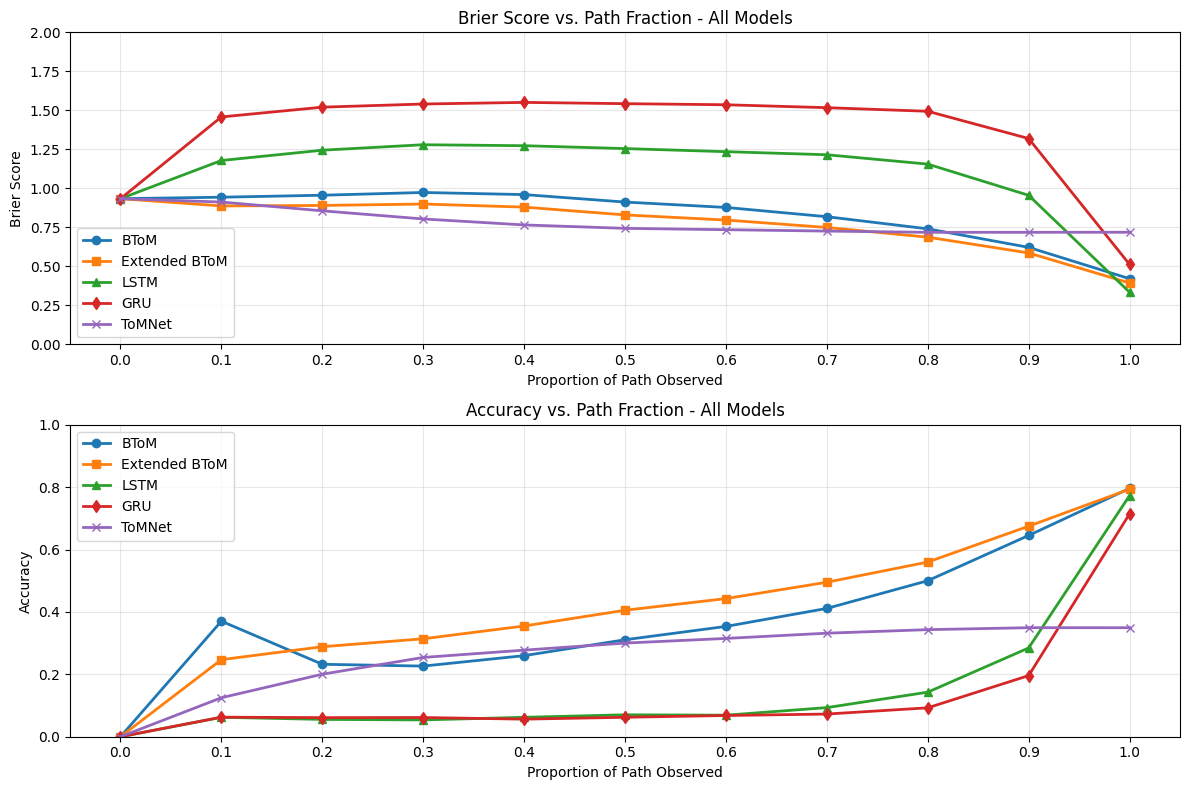

In [124]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose `scores` is your (n_trajectories × n_fractions) array:
arr = np.array(scores)  # shape (N, 11)
ext_arr = np.array(ext_scores)
lstm_arr = np.array(lstm_scores)
gru_arr = np.array(gru_scores)
tomnet_arr = np.array(tomnet_scores)
# tomnet_causal_arr = np.array(tomnet_causal_scores)
props = np.linspace(0, 1, arr.shape[1])

# Compute mean
mean_base = arr.mean(axis=0)
mean_ext = ext_arr.mean(axis=0)
mean_lstm = lstm_arr.mean(axis=0)
mean_gru = gru_arr.mean(axis=0)
mean_tomnet = tomnet_arr.mean(axis=0)
# mean_tomnet_causal = tomnet_causal_arr.mean(axis=0)

plt.figure(figsize=(12, 8))

# Brier Score Plot
plt.subplot(2, 1, 1)
plt.plot(props, mean_base, '-o', label='BToM', linewidth=2, markersize=6)
plt.plot(props, mean_ext, '-s', label='Extended BToM', linewidth=2, markersize=6)
plt.plot(props, mean_lstm, '-^', label='LSTM', linewidth=2, markersize=6)
plt.plot(props, mean_gru, '-d', label='GRU', linewidth=2, markersize=6)
plt.plot(props, mean_tomnet, '-x', label='ToMNet', linewidth=2, markersize=6)
# plt.plot(props, mean_tomnet_causal, '-*', label='TomNetCausal (SOTA)', linewidth=3, markersize=8, color='red')

plt.xlabel('Proportion of Path Observed')
plt.ylabel('Brier Score')
plt.title('Brier Score vs. Path Fraction - All Models')
plt.xticks(props)
plt.ylim(0, 2)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Accuracy Plot
plt.subplot(2, 1, 2)
arr_acc = np.array(btom_acc)
ext_arr_acc = np.array(ext_acc)
lstm_arr_acc = np.array(lstm_acc)
gru_arr_acc = np.array(gru_acc)
tomnet_arr_acc = np.array(tomnet_acc)
# tomnet_causal_arr_acc = np.array(tomnet_causal_acc)

mean_base_acc = arr_acc.mean(axis=0)
mean_ext_acc = ext_arr_acc.mean(axis=0)
mean_lstm_acc = lstm_arr_acc.mean(axis=0)
mean_gru_acc = gru_arr_acc.mean(axis=0)
mean_tomnet_acc = tomnet_arr_acc.mean(axis=0)
# mean_tomnet_causal_acc = tomnet_causal_arr_acc.mean(axis=0)

plt.plot(props, mean_base_acc, '-o', label='BToM', linewidth=2, markersize=6)
plt.plot(props, mean_ext_acc, '-s', label='Extended BToM', linewidth=2, markersize=6)
plt.plot(props, mean_lstm_acc, '-^', label='LSTM', linewidth=2, markersize=6)
plt.plot(props, mean_gru_acc, '-d', label='GRU', linewidth=2, markersize=6)
plt.plot(props, mean_tomnet_acc, '-x', label='ToMNet', linewidth=2, markersize=6)
# plt.plot(props, mean_tomnet_causal_acc, '-*', label='TomNetCausal (SOTA)', linewidth=3, markersize=8, color='red')

plt.xlabel('Proportion of Path Observed')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Path Fraction - All Models')
plt.xticks(props)
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

plt.show()

In [126]:
import numpy as np
import matplotlib.pyplot as plt

# Filter out any entries that are not 1D arrays/lists of the same length
filtered_scores = [s for s in tomnet_causal_scores if isinstance(s, (list, np.ndarray)) and len(s) > 1]
if not filtered_scores:
    print("No valid tomnet_causal_scores to plot.")
else:
    min_len = min(len(s) for s in filtered_scores)
    # Optionally, trim all to the same length
    filtered_scores = [s[:min_len] for s in filtered_scores]
    tomnet_causal_arr = np.array(filtered_scores)
    print("tomnet_causal_arr.shape:", tomnet_causal_arr.shape)

    props = np.linspace(0, 1, tomnet_causal_arr.shape[1])
    mean_tomnet_causal = tomnet_causal_arr.mean(axis=0)

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(props, mean_tomnet_causal, '-*', label='TomNetCausal (SOTA)', linewidth=3, markersize=8, color='red')
    plt.xlabel('Proportion of Path Observed')
    plt.ylabel('Brier Score')
    plt.title('Brier Score vs. Path Fraction - All Models')
    plt.xticks(props)
    plt.ylim(0, 2)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    # Accuracy Plot
    filtered_acc = [a[:min_len] for a in tomnet_causal_acc if isinstance(a, (list, np.ndarray)) and len(a) >= min_len]
    tomnet_causal_arr_acc = np.array(filtered_acc)
    mean_tomnet_causal_acc = tomnet_causal_arr_acc.mean(axis=0)
    plt.subplot(2, 1, 2)
    plt.plot(props, mean_tomnet_causal_acc, '-*', label='TomNetCausal (SOTA)', linewidth=3, markersize=8, color='red')
    plt.xlabel('Proportion of Path Observed')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Path Fraction - All Models')
    plt.xticks(props)
    plt.ylim(0, 1)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

No valid tomnet_causal_scores to plot.


In [127]:
import numpy as np
import matplotlib.pyplot as plt

tomnet_causal_arr = np.array(tomnet_causal_scores)
print("tomnet_causal_arr.shape:", tomnet_causal_arr.shape)

if tomnet_causal_arr.ndim != 2:
    print("WARNING: tomnet_causal_arr is not 2D. Check your data. Skipping plot.")
else:
    props = np.linspace(0, 1, tomnet_causal_arr.shape[1])

    mean_tomnet_causal = tomnet_causal_arr.mean(axis=0)

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(props, mean_tomnet_causal, '-*', label='TomNetCausal (SOTA)', linewidth=3, markersize=8, color='red')
    plt.xlabel('Proportion of Path Observed')
    plt.ylabel('Brier Score')
    plt.title('Brier Score vs. Path Fraction - All Models')
    plt.xticks(props)
    plt.ylim(0, 2)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    # Accuracy Plot
    tomnet_causal_arr_acc = np.array(tomnet_causal_acc)
    mean_tomnet_causal_acc = tomnet_causal_arr_acc.mean(axis=0)
    plt.subplot(2, 1, 2)
    plt.plot(props, mean_tomnet_causal_acc, '-*', label='TomNetCausal (SOTA)', linewidth=3, markersize=8, color='red')
    plt.xlabel('Proportion of Path Observed')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Path Fraction - All Models')
    plt.xticks(props)
    plt.ylim(0, 1)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

tomnet_causal_arr.shape: (0,)


In [129]:

# Print summary statistics
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)

print(f"\nBrier Score (Lower is Better):")
print(f"BToM: {mean_base.mean():.4f} ± {mean_base.std():.4f}")
print(f"Extended BToM: {mean_ext.mean():.4f} ± {mean_ext.std():.4f}")
print(f"LSTM: {mean_lstm.mean():.4f} ± {mean_lstm.std():.4f}")
print(f"GRU: {mean_gru.mean():.4f} ± {mean_gru.std():.4f}")
print(f"ToMNet: {mean_tomnet.mean():.4f} ± {mean_tomnet.std():.4f}")
# print(f"TomNetCausal (SOTA): {mean_tomnet_causal.mean():.4f} ± {mean_tomnet_causal.std():.4f}")

print(f"\nAccuracy (Higher is Better):")
print(f"BToM: {mean_base_acc.mean():.4f} ± {mean_base_acc.std():.4f}")
print(f"Extended BToM: {mean_ext_acc.mean():.4f} ± {mean_ext_acc.std():.4f}")
print(f"LSTM: {mean_lstm_acc.mean():.4f} ± {mean_lstm_acc.std():.4f}")
print(f"GRU: {mean_gru_acc.mean():.4f} ± {mean_gru_acc.std():.4f}")
print(f"ToMNet: {mean_tomnet_acc.mean():.4f} ± {mean_tomnet_acc.std():.4f}")
# print(f"TomNetCausal (SOTA): {mean_tomnet_causal_acc.mean():.4f} ± {mean_tomnet_causal_acc.std():.4f}")

# Save results
results = {
    'brier_scores': {
        'btom': mean_base.tolist(),
        'extended_btom': mean_ext.tolist(),
        'lstm': mean_lstm.tolist(),
        'gru': mean_gru.tolist(),
        'tomnet': mean_tomnet.tolist(),
        # 'tomnet_causal': mean_tomnet_causal.tolist()
    },
    'accuracy_scores': {
        'btom': mean_base_acc.tolist(),
        'extended_btom': mean_ext_acc.tolist(),
        'lstm': mean_lstm_acc.tolist(),
        'gru': mean_gru_acc.tolist(),
        'tomnet': mean_tomnet_acc.tolist(),
        # 'tomnet_causal': mean_tomnet_causal_acc.tolist()
    }
}

import json
with open('experiment_0_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nResults saved to experiment_0_results.json")
print("="*60)


MODEL PERFORMANCE SUMMARY

Brier Score (Lower is Better):
BToM: 0.8320 ± 0.1665
Extended BToM: 0.7752 ± 0.1570
LSTM: 1.0959 ± 0.2669
GRU: 1.3565 ± 0.3182
ToMNet: 0.7841 ± 0.0770

Accuracy (Higher is Better):
BToM: 0.3733 ± 0.2063
Extended BToM: 0.4161 ± 0.2066
LSTM: 0.1516 ± 0.2086
GRU: 0.1316 ± 0.1896
ToMNet: 0.2588 ± 0.1055

Results saved to experiment_0_results.json


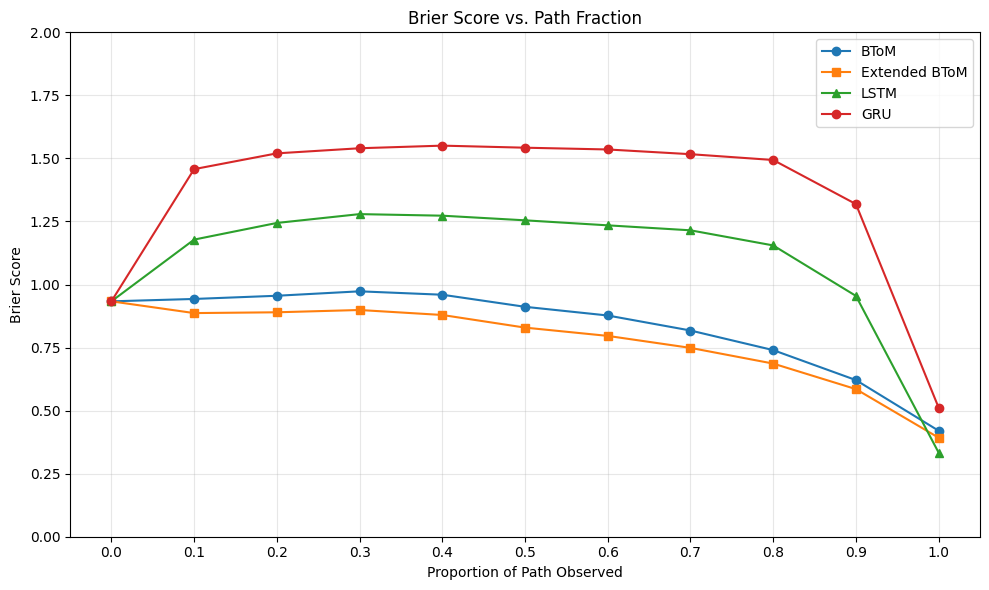

In [130]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose `scores` is your (n_trajectories × n_fractions) array:
arr = np.array(scores)  # shape (N, 11)
ext_arr  = np.array(ext_scores)
#tomnet_arr = np.array(tomnet_scores)
lstm_arr = np.array(lstm_scores)
gru_arr = np.array(gru_scores)
props = np.linspace(0, 1, arr.shape[1])

# Compute mean
mean_base = arr.mean(axis=0)
mean_ext  = ext_arr.mean(axis=0)
#mean_tomnet = tomnet_arr.mean(axis=0)
mean_lstm = lstm_arr.mean(axis=0)
mean_gru = gru_arr.mean(axis=0)

plt.figure(figsize=(10,6))
plt.plot(props, mean_base, '-o', label='BToM')
plt.plot(props, mean_ext,  '-s', label='Extended BToM')
#plt.plot(props, mean_tomnet, '-o', label='ToMNet')
plt.plot(props, mean_lstm, '-^', label='LSTM')
plt.plot(props, mean_gru, '-o', label='GRU')

plt.xlabel('Proportion of Path Observed')
plt.ylabel('Brier Score')
plt.title('Brier Score vs. Path Fraction')
plt.xticks(props)
plt.ylim(0, 2)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


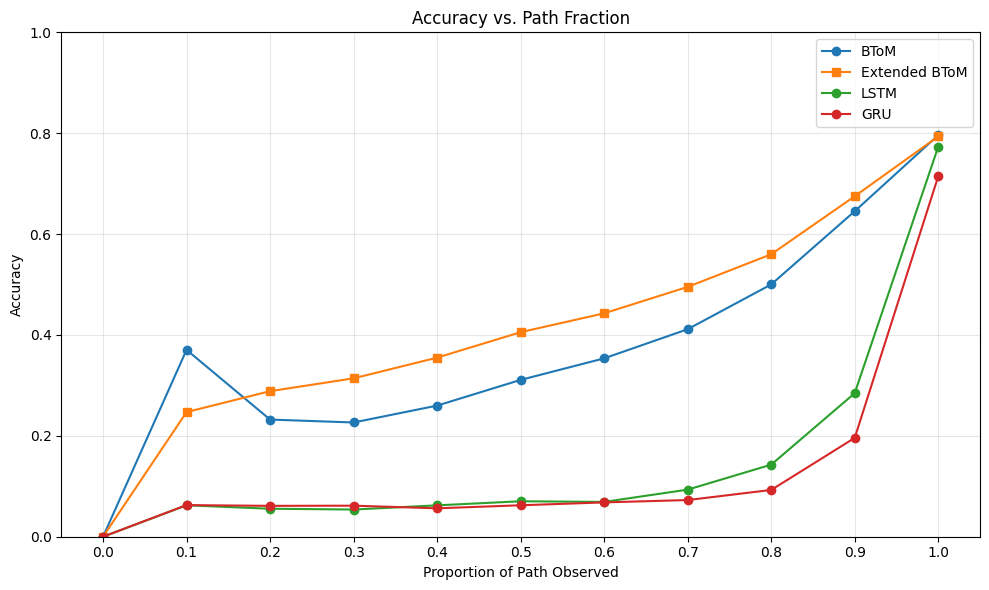

In [131]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose `scores` is your (n_trajectories × n_fractions) array:
arr = np.array(btom_acc)  # shape (N, 11)
ext_arr  = np.array(ext_acc)
#tom_arr = np.array(tomnet_acc)
lstm_arr = np.array(lstm_acc)
gru_arr = np.array(gru_acc)
props = np.linspace(0, 1, arr.shape[1])

# Compute mean
mean_base = arr.mean(axis=0)
mean_ext  = ext_arr.mean(axis=0)
#mean_tom  = tom_arr.mean(axis=0)
mean_lstm  = lstm_arr.mean(axis=0)
mean_gru  = gru_arr.mean(axis=0)


plt.figure(figsize=(10,6))
plt.plot(props, mean_base, '-o', label='BToM')
plt.plot(props, mean_ext,  '-s', label='Extended BToM')
#plt.plot(props, mean_tom, '-o', label='ToMNet')
plt.plot(props, mean_lstm, '-o', label='LSTM')
plt.plot(props, mean_gru, '-o', label='GRU')

plt.xlabel('Proportion of Path Observed')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Path Fraction')
plt.xticks(props)
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

1. Use geospatial coordinates instead of IDs for nodes
2. Consider an embedding for the nodes --  we are using an embedding for the nodes
3. Consider multi head loss
4. Consider other loss functions for the distribution
5. The character net has a strange input where the multiple past trajs are concatenated